In [1]:
# Imports and physical parameters
import numpy as np
import scipy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from ipywidgets import *
from matplotlib.widgets import Slider
from lsm import HNdC_ijk

# ddg imports
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from ddgclib._complex import Complex
from ddgclib import *
from ddgclib._complex import *
from ddgclib._curvatures import * #plot_surface#, curvature
from ddgclib._capillary_rise_flow import * #plot_surface#, curvature
from ddgclib._hyperboloid import *
from ddgclib._catenoid import *
from ddgclib._ellipsoid import *
from ddgclib._eos import *
from ddgclib._misc import *
from ddgclib._plotting import *
from ddgclib._sphere import *
#from ddgclib._case2 import *

# Numerical parameters #Stated this is what to pla
N = 7  # Determines mesh incidence
refinement = 1

r = 2  # analytical area = 2 pi r**2, so take 2 pi
HC = sphere_from_cap(r, N=N, refinement=refinement)


if 1:
    HC.plot_complex()
    plt.show()

# Plot conforimation
if 0:
    ps = plot_polyscope(HC, vector_field=None, scalar_field=None, fn='', up="x_up"
                        , stl=False)
    ps.show()

/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2832: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_complex.show()


<Figure size 640x480 with 0 Axes>

In [2]:
refinement = 3

r = 2  # analytical area = 2 pi r**2, so take 2 pi
HC = sphere_from_cap(r, N=N, refinement=refinement)


if 1:
    HC.plot_complex()
    plt.show()


<Figure size 640x480 with 0 Axes>

In [3]:
# Compute the curvature
HNdA_i = []  # total HNdA_i at vertex i
A_ijk = []  # total HNdA_i for edge ij
C_ij = []
alpha_ij = []
NdA_i = []

for v in HC.V:
    #print(f'v.index = {v.index}')
    N_f0 = v.x_a - np.array([0.0, 0.0, 0.0])  # First approximation
    N_f0 = normalized(N_f0)[0]
    F, nn = vectorise_vnn(v)
    # Compute discrete curvatures
    c_outd = b_curvatures_hn_ij_c_ij(F, nn, n_i=N_f0)
    # Append lists
    c_outd['HNdA_ij']
    HNdA_i.append(c_outd['HNdA_i'])
    C_ij.append(c_outd['C_ij'])
    alpha_ij.append(c_outd['alpha_ij'])
    A_ijk.append(c_outd['A_ijk'])
    #print(f'N_f0 dot = {N_f0}')
    np.dot(N_f0, c_outd['HNdA_i'])
    NdA_i.append(c_outd['NdA_i'])
    
   # print(f"np.dot(N_f0, c_outd['HNdA_i'])/np.sum(c_outd['C_ij']) = {np.dot(N_f0, c_outd['HNdA_i'])/np.sum(c_outd['C_ij'])}")

# [0]
# HNdA_i = 0.5 * np.sum(HNdA_ij, axis=0)
# HN_i = np.sum(HNdA_i) / np.sum(C_ij)
#HNdA_ij, HN_i, HNdA_i, C_ij, alpha_ij
print(f'np.sum(HNdA_i, axis=0) = {np.sum(HNdA_i, axis=0)}')
#print(f'HNdA_i[0] = {HNdA_i[0]}')
#print(f'nn = {nn}')
#print(f'F= {F}')
NdA_i = np.array(NdA_i)
print(f'NdA_i = {NdA_i}')



np.sum(HNdA_i, axis=0) = [-9.48676901e-20  3.38813179e-19 -2.50721752e-19]
NdA_i = [[ 0.00000000e+00  0.00000000e+00 -8.11898816e-01]
 [-1.34621770e-18  3.82359556e-02  0.00000000e+00]
 [ 3.31133089e-02  1.91179778e-02  0.00000000e+00]
 ...
 [-5.81531877e-02  6.74100545e-02  2.39812004e-02]
 [-5.30235461e-02  5.52887406e-02  1.01962433e-02]
 [-4.59388924e-02  6.63886701e-02  1.08005842e-02]]


# Theoretical areas tested:

### Discrete dual area

The scalar value of the dual areas taken from :

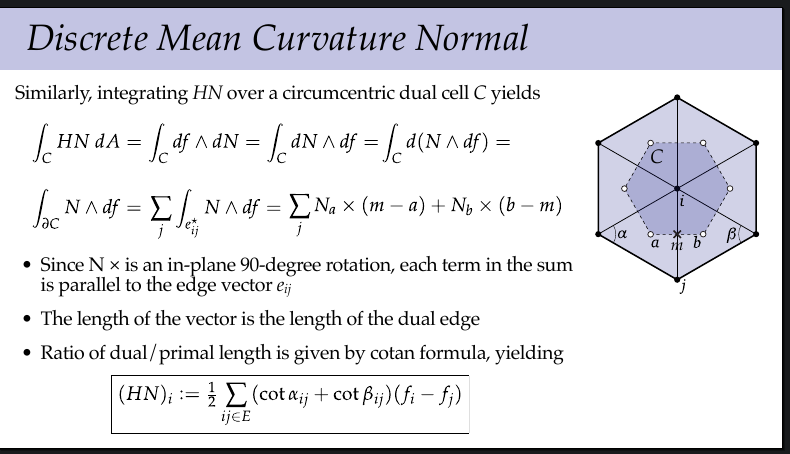


### Discrete vector area

The summed vector area:

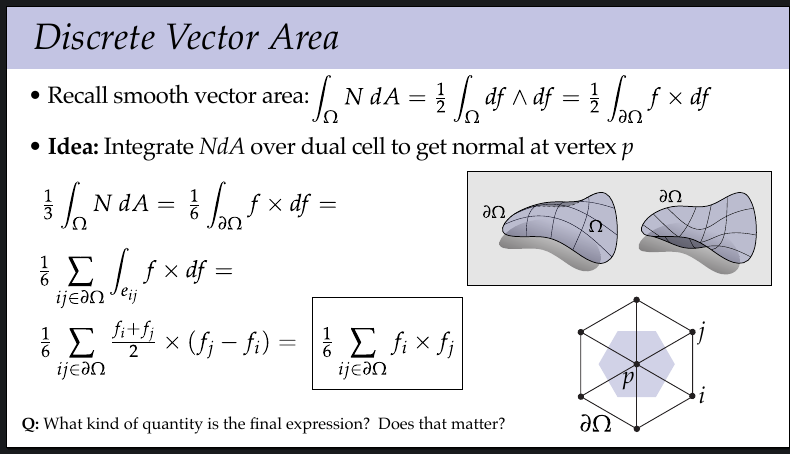


### Angle defect (area on a unit sphere)

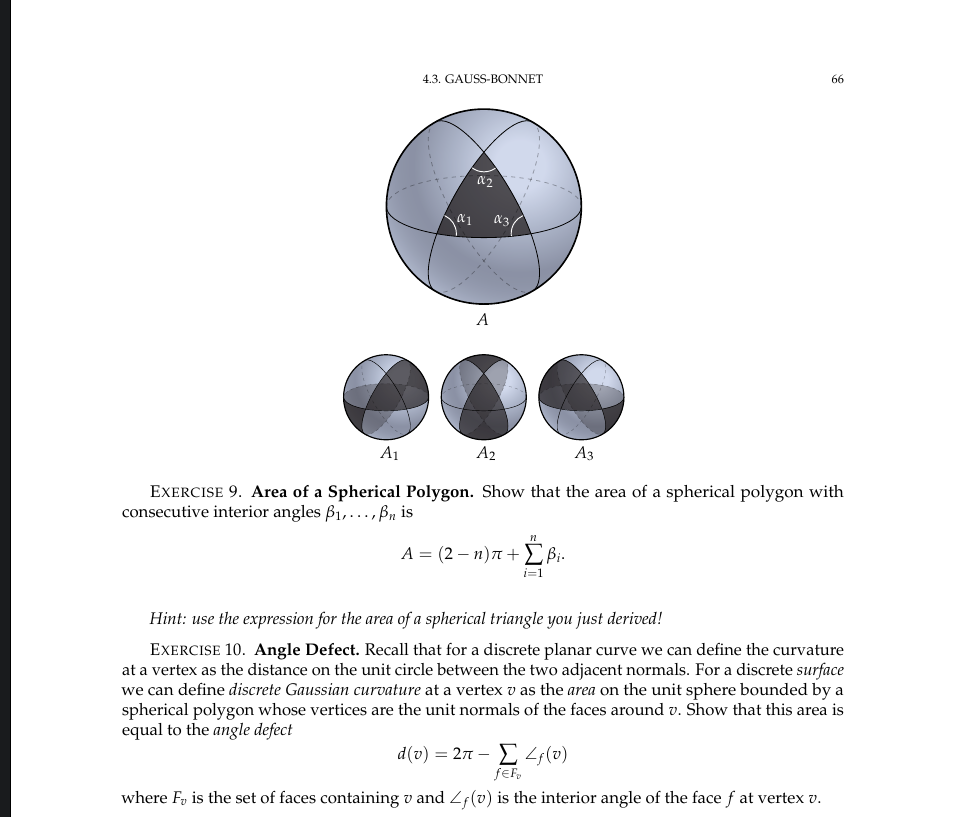


### Voronoi region area 

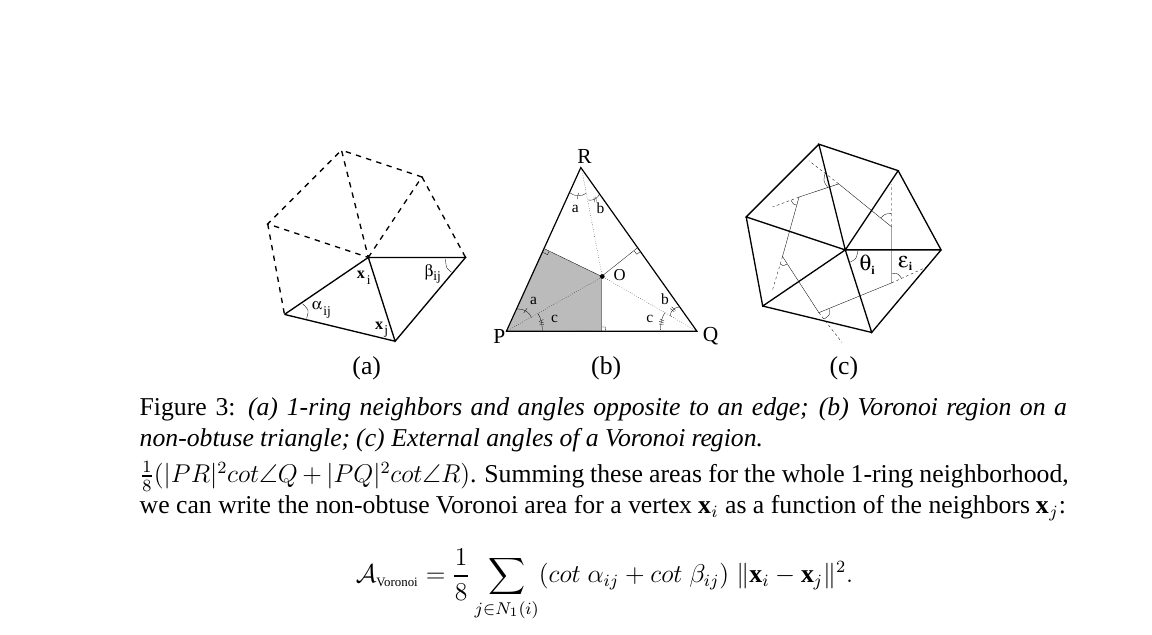

In [4]:
def A_voronoi_ijk(e_ij, l_ij, l_jk, l_ik):
    lengths = [l_ij, l_jk, l_ik]
    # Sort the list, python sorts from the smallest to largest element:
    lengths.sort()
    # We must have use a ≥ b ≥ c in floating-point stable Heron's formula:
    a = lengths[2]
    b = lengths[1]
    c = lengths[0]
    A = (1 / 4.0) * np.sqrt((a + (b + c)) * (c - (a - b)) * (c + (a - b)) * (a + (b - c)))
    # Dual weights (scalar):
    w_ij = (1 / 8.0) * (l_jk ** 2 + l_ik ** 2 - l_ij ** 2) / A   # w_ij = abs(w_ij)

    # Mean normal curvature (1x3 vector):
    hnda_ijk = w_ij * np.linalg.norm(e_ij)**2  # curvature from this edge jk in triangle ijk with w_jk = 1/2 cot(theta_i^jk)
    hnda_ijk = (1/4.0) * hnda_ijk
    # Dual areas
    h_ij = 0.5 * l_ij
    b_ij = abs(w_ij) * l_ij  # = ||0.5 cot(theta_i^jk)|| * 0.5*l_ij
    c_ijk = 0.5 * b_ij * h_ij
    return hnda_ijk, c_ijk


def dA_vor(v, n_i=None):

    # NOTE: THIS MUST BE REPLACED WITH THE LEVEL SET PLANE VECTOR:
    if n_i is not None:
        n_i = v.x

    # Initiate
    HNdA_i = np.zeros(1)  # np.zeros([len(v.nn), 3])  # Mean normal curvature 
    C_i = 0.0  # np.zeros([len(v.nn), 3])  # Dual area around edge in a surface
    vi = v
    for vj in v.nn:
        # Compute the intersection set of vertices i and j:
        e_i_int_e_j = vi.nn.intersection(vj.nn)  # Set of size 1 or 2
        e_ij = vj.x_a - vi.x_a  # Compute edge ij (1x3 vector)
        e_ij = - e_ij  # WHY???
        vk = list(e_i_int_e_j)[0]  # index in triangle ijk  # NOTE: k = vk.index
        e_ik = vk.x_a - vi.x_a  # Compute edge ik (1x3 vector)
        
        #NOTE: The code below results in the INCORRECT values unless we set
        #      e_ij = - e_ij  # WHY???
        if 0:
            # Discrete vector area:
            # Simplex areas of ijk and normals
            wedge_ij_ik = np.cross(e_ij, e_ik)
            # If the wrong direction was chosen, choose the other:
          #  print(f'np.dot(normalized(wedge_ij_ik)[0], n_i) = {np.dot(normalized(wedge_ij_ik)[0], n_i)}')
            if np.dot(normalized(wedge_ij_ik)[0], n_i) < 0:
                e_ij = vi.x_a - vj.x_a
                #e_ij = vi.x_a - vj.x_a
              #  e_ij = vj.x_a - vi.x_a  # Does not appear to be needed, 
              #                          # but more tests need to be done

        if len(e_i_int_e_j) == 1:  # boundary edge
            print(f'BOUNDARY EDGE WARNING!!')
            vk = list(e_i_int_e_j)[0]  # Boundary edge index
            # Compute edges in triangle ijk
            e_ik = vk.x_a - vi.x_a
            e_jk = vk.x_a - vj.x_a
            # Find lengths (norm of the edge vectors):
            l_ij = np.linalg.norm(e_ij)
            l_ik = np.linalg.norm(e_ik)  # NOTE: l_ki = l_ik
            l_jk = np.linalg.norm(e_jk)
            hnda_ijk, c_ijk = A_voronoi_ijk(e_ij, l_ij, l_jk, l_ik)
            
            # Save results
            HNdA_i += hnda_ijk
            C_i += c_ijk

        else:  # len(e_i_int_e_j) == 2 mathematically guaranteed:
            vl = list(e_i_int_e_j)[1]  # index in triangle ijl
            # Compute dual for contact angle alpha
            e_jk = vk.x_a - vj.x_a
            # wedge_ij_ik = np.cross(e_ij, e_ik)
            # Find lengths (norm of the edge vectors):
            l_ij = np.linalg.norm(e_ij)
            l_ik = np.linalg.norm(e_ik)  # NOTE: l_ki = l_ik
            l_jk = np.linalg.norm(e_jk)
            hnda_ijk, c_ijk = A_voronoi_ijk(e_ij, l_ij, l_jk, l_ik)

            # Contact angle beta
            e_il = vl.x_a - vi.x_a
            e_jl = vl.x_a - vj.x_a
            l_il = np.linalg.norm(e_il)  # NOTE: l_ki = l_ik
            l_jl = np.linalg.norm(e_jl)
            hnda_ijl, c_ijl = A_voronoi_ijk(e_ij, l_ij, l_jl, l_il)

            # Save results
            HNdA_i += hnda_ijk
            HNdA_i += hnda_ijl
            C_i += c_ijl
            C_i += c_ijk

    return HNdA_i, C_i



In [5]:
np.linalg.norm([1, 2, 3])**2, 3.7416573867739413**2,

(14.0, 14.0)

In [6]:
def HNdC_ijk(e_ij, l_ij, l_jk, l_ik):
    """
    Computes the dual edge and dual area using Heron's formula.

    :param e_ij: vector, edge e_ij
    :param l_ij: float, length of edge ij
    :param l_jk: float, length of edge jk
    :param l_ik: float, length of edge ik
    :return: hnda_ijk: vector, curvature vector
             c_ijk: float, dual areas
    """
    lengths = [l_ij, l_jk, l_ik]
    # Sort the list, python sorts from the smallest to largest element:
    lengths.sort()
    # We must have use a ≥ b ≥ c in floating-point stable Heron's formula:
    a = lengths[2]
    b = lengths[1]
    c = lengths[0]
    A = (1 / 4.0) * np.sqrt((a + (b + c)) * (c - (a - b)) * (c + (a - b)) * (a + (b - c)))
    # Dual weights (scalar):
    w_ij = (1 / 8.0) * (l_jk ** 2 + l_ik ** 2 - l_ij ** 2) / A   # w_ij = abs(w_ij)

    # Mean normal curvature (1x3 vector):
    hnda_ijk = w_ij * e_ij  # curvature from this edge jk in triangle ijk with w_jk = 1/2 cot(theta_i^jk)

    # Dual areas
    h_ij = 0.5 * l_ij
    b_ij = abs(w_ij) * l_ij  # = ||0.5 cot(theta_i^jk)|| * 0.5*l_ij
    c_ijk = 0.5 * b_ij * h_ij
    return hnda_ijk, c_ijk

def A_i(v, n_i=None):
    """
    Compute the discrete normal area of vertex v_i
    
    :param v: vertex object
    :return: HNdA_i: the curvature tensor at input vertex v 
             c_i:  the dual area of the vertex
    """
    # NOTE: THIS MUST BE REPLACED WITH THE LEVEL SET PLANE VECTOR:
    if n_i is not None:
        n_i = v.x

    # Initiate
    NdA_i = np.zeros(3)  # np.zeros([len(v.nn), 3])  # Mean normal curvature 
    C_i = 0.0  # np.zeros([len(v.nn), 3])  # Dual area around edge in a surface
    vi = v
    for vj in v.nn:
        # Compute the intersection set of vertices i and j:
        e_i_int_e_j = vi.nn.intersection(vj.nn)  # Set of size 1 or 2
        e_ij = vj.x_a - vi.x_a  # Compute edge ij (1x3 vector)
        e_ij = - e_ij  # WHY???
        vk = list(e_i_int_e_j)[0]  # index in triangle ijk  # NOTE: k = vk.index
        e_ik = vk.x_a - vi.x_a  # Compute edge ik (1x3 vector)
        
        #NOTE: The code below results in the INCORRECT values unless we set
        #      e_ij = - e_ij  # WHY???
        if 1:
            # Discrete vector area:
            # Simplex areas of ijk and normals
            wedge_ij_ik = np.cross(e_ij, e_ik)
            # If the wrong direction was chosen, choose the other:
          #  print(f'np.dot(normalized(wedge_ij_ik)[0], n_i) = {np.dot(normalized(wedge_ij_ik)[0], n_i)}')
            if np.dot(normalized(wedge_ij_ik)[0], n_i) < 0:
                print(f'e_ij_prev = {e_ij}')
                e_ij = vi.x_a - vj.x_a
                #e_ij = vi.x_a - vj.x_a
              #  e_ij = vj.x_a - vi.x_a  # Does not appear to be needed, 
              #                          # but more tests need to be done

        if len(e_i_int_e_j) == 1:  # boundary edge
            pass # ignore for now 

        else:  # len(e_i_int_e_j) == 2 mathematically guaranteed:
            vl = list(e_i_int_e_j)[1]  # index in triangle ijl
            # Compute dual for contact angle alpha
            e_jk = vk.x_a - vj.x_a
            # wedge_ij_ik = np.cross(e_ij, e_ik)
            # Find lengths (norm of the edge vectors):
            l_ij = np.linalg.norm(e_ij)
            l_ik = np.linalg.norm(e_ik)  # NOTE: l_ki = l_ik
            l_jk = np.linalg.norm(e_jk)
            hnda_ijk, c_ijk = HNdC_ijk(e_ij, l_ij, l_jk, l_ik)

            # Contact angle beta
            e_il = vl.x_a - vi.x_a
            e_jl = vl.x_a - vj.x_a
            l_il = np.linalg.norm(e_il)  # NOTE: l_ki = l_ik
            l_jl = np.linalg.norm(e_jl)
            hnda_ijl, c_ijl = HNdC_ijk(e_ij, l_ij, l_jl, l_il)

            # Save results
            HNdA_i += hnda_ijk
            HNdA_i += hnda_ijl
            C_i += c_ijl
            C_i += c_ijk

    return NdA_i#, C_i


#TODO: Since sparse arrays are too expensive to recreate and add to,
#      we might want cache edge lengths instead. higher dimensional
#      simplices could be done with a lexigraphic cache.
#      This is simple to parallelise on CPUs, but might be much harder
#      to do on GPUs.

def hndA_i(v, n_i=None):
    """
    Compute the mean normal curvature of vertex
    
    :param v: vertex object
    :return: HNdA_i: the curvature tensor at input vertex v 
             c_i:  the dual area of the vertex
    """
    # NOTE: THIS MUST BE REPLACED WITH THE LEVEL SET PLANE VECTOR:
    if n_i is not None:
        n_i = v.x

    # Initiate
    HNdA_i = np.zeros(3)  # np.zeros([len(v.nn), 3])  # Mean normal curvature 
    C_i = 0.0  # np.zeros([len(v.nn), 3])  # Dual area around edge in a surface
    vi = v
    for vj in v.nn:
        # Compute the intersection set of vertices i and j:
        e_i_int_e_j = vi.nn.intersection(vj.nn)  # Set of size 1 or 2
        e_ij = vj.x_a - vi.x_a  # Compute edge ij (1x3 vector)
        e_ij = - e_ij  # WHY???
        vk = list(e_i_int_e_j)[0]  # index in triangle ijk  # NOTE: k = vk.index
        e_ik = vk.x_a - vi.x_a  # Compute edge ik (1x3 vector)
        
        #NOTE: The code below results in the INCORRECT values unless we set
        #      e_ij = - e_ij  # WHY???
        if 0:
            # Discrete vector area:
            # Simplex areas of ijk and normals
            wedge_ij_ik = np.cross(e_ij, e_ik)
            # If the wrong direction was chosen, choose the other:
          #  print(f'np.dot(normalized(wedge_ij_ik)[0], n_i) = {np.dot(normalized(wedge_ij_ik)[0], n_i)}')
            if np.dot(normalized(wedge_ij_ik)[0], n_i) < 0:
                e_ij = vi.x_a - vj.x_a
                #e_ij = vi.x_a - vj.x_a
              #  e_ij = vj.x_a - vi.x_a  # Does not appear to be needed, 
              #                          # but more tests need to be done

        if len(e_i_int_e_j) == 1:  # boundary edge
            vk = list(e_i_int_e_j)[0]  # Boundary edge index
            # Compute edges in triangle ijk
            e_ik = vk.x_a - vi.x_a
            e_jk = vk.x_a - vj.x_a
            # Find lengths (norm of the edge vectors):
            l_ij = np.linalg.norm(e_ij)
            l_ik = np.linalg.norm(e_ik)  # NOTE: l_ki = l_ik
            l_jk = np.linalg.norm(e_jk)
            hnda_ijk, c_ijk = HNdC_ijk(e_ij, l_ij, l_jk, l_ik)
            
            # Save results
            HNdA_i += hnda_ijk
            C_i += c_ijk

        else:  # len(e_i_int_e_j) == 2 mathematically guaranteed:
            vl = list(e_i_int_e_j)[1]  # index in triangle ijl
            # Compute dual for contact angle alpha
            e_jk = vk.x_a - vj.x_a
            # wedge_ij_ik = np.cross(e_ij, e_ik)
            # Find lengths (norm of the edge vectors):
            l_ij = np.linalg.norm(e_ij)
            l_ik = np.linalg.norm(e_ik)  # NOTE: l_ki = l_ik
            l_jk = np.linalg.norm(e_jk)
            hnda_ijk, c_ijk = HNdC_ijk(e_ij, l_ij, l_jk, l_ik)

            # Contact angle beta
            e_il = vl.x_a - vi.x_a
            e_jl = vl.x_a - vj.x_a
            l_il = np.linalg.norm(e_il)  # NOTE: l_ki = l_ik
            l_jl = np.linalg.norm(e_jl)
            hnda_ijl, c_ijl = HNdC_ijk(e_ij, l_ij, l_jl, l_il)

            # Save results
            HNdA_i += hnda_ijk
            HNdA_i += hnda_ijl
            C_i += c_ijl
            C_i += c_ijk

    return HNdA_i, C_i

# Start main loop
HNdA_ijk_l, C_ijk_l = [], []
C = 0
HNdA = np.zeros(3)
for v in HC.V:
    n_i = v.x_a - np.array([0.0, 0.0, 0.0])  # First approximation
    n_i = normalized(n_i)[0]  
    n_test = n_i + (np.random.rand(3) - 0.5)
    HNdA_i, C_i = hndA_i(v, n_i=n_test)
    C += C_i
    HNdA += HNdA_i
    #print(f"np.dot(n_i, HNdA_i)/C_i, n_i, HNdA_i = {np.dot(n_i, HNdA_i)/C_i}")
    #break
    
def int_HNdC_ijk(e_ij, l_ij, l_jk, l_ik):
    """
    Computes the dual edge and dual area using Heron's formula.

    :param e_ij: vector, edge e_ij
    :param l_ij: float, length of edge ij
    :param l_jk: float, length of edge jk
    :param l_ik: float, length of edge ik
    :return: hnda_ijk: vector, curvature vector
             c_ijk: float, dual areas
    """
    lengths = [l_ij, l_jk, l_ik]
    # Sort the list, python sorts from the smallest to largest element:
    lengths.sort()
    # We must have use a ≥ b ≥ c in floating-point stable Heron's formula:
    a = lengths[2]
    b = lengths[1]
    c = lengths[0]
    A = (1 / 4.0) * np.sqrt((a + (b + c)) * (c - (a - b)) * (c + (a - b)) * (a + (b - c)))
    # Dual weights (scalar):
    w_ij = (1 / 8.0) * (l_jk ** 2 + l_ik ** 2 - l_ij ** 2) / A   # w_ij = abs(w_ij)

    # Mean normal curvature (1x3 vector):
    hnda_ijk = w_ij * e_ij  # curvature from this edge jk in triangle ijk with w_jk = 1/2 cot(theta_i^jk)

    # Dual areas
    h_ij = 0.5 * l_ij
    b_ij = abs(w_ij) * l_ij  # = ||0.5 cot(theta_i^jk)|| * 0.5*l_ij
    c_ijk = 0.5 * b_ij * h_ij
    return hnda_ijk, c_ijk


def int_hndA_i(v, n_i=None):
    """
    Compute the mean normal curvature of vertex
    
    :param v: vertex object
    :return: HNdA_i: the curvature tensor at input vertex v 
             c_i:  the dual area of the vertex
    """
    # NOTE: THIS MUST BE REPLACED WITH THE LEVEL SET PLANE VECTOR:
    if n_i is not None:
        n_i = v.x

    # Initiate
    HNdA_i = np.zeros(3)  # np.zeros([len(v.nn), 3])  # Mean normal curvature 
    C_i = 0.0  # np.zeros([len(v.nn), 3])  # Dual area around edge in a surface
    vi = v
    for vj in v.nn:
        # Compute the intersection set of vertices i and j:
        e_i_int_e_j = vi.nn.intersection(vj.nn)  # Set of size 1 or 2
        e_ij = vj.x_a - vi.x_a  # Compute edge ij (1x3 vector)
        e_ij = - e_ij  # WHY???
        vk = list(e_i_int_e_j)[0]  # index in triangle ijk  # NOTE: k = vk.index
        e_ik = vk.x_a - vi.x_a  # Compute edge ik (1x3 vector)
        
        #NOTE: The code below results in the INCORRECT values unless we set
        #      e_ij = - e_ij  # WHY???
        if 0:
            # Discrete vector area:
            # Simplex areas of ijk and normals
            wedge_ij_ik = np.cross(e_ij, e_ik)
            # If the wrong direction was chosen, choose the other:
          #  print(f'np.dot(normalized(wedge_ij_ik)[0], n_i) = {np.dot(normalized(wedge_ij_ik)[0], n_i)}')
            if np.dot(normalized(wedge_ij_ik)[0], n_i) < 0:
                e_ij = vi.x_a - vj.x_a
                #e_ij = vi.x_a - vj.x_a
              #  e_ij = vj.x_a - vi.x_a  # Does not appear to be needed, 
              #                          # but more tests need to be done

        if len(e_i_int_e_j) == 1:  # boundary edge
            vk = list(e_i_int_e_j)[0]  # Boundary edge index
            # Compute edges in triangle ijk
            e_ik = vk.x_a - vi.x_a
            e_jk = vk.x_a - vj.x_a
            # Find lengths (norm of the edge vectors):
            l_ij = np.linalg.norm(e_ij)
            l_ik = np.linalg.norm(e_ik)  # NOTE: l_ki = l_ik
            l_jk = np.linalg.norm(e_jk)
            
            e_hnda_ij = vj.hnda_i - vi.hnda_i
            hnda_ijk, c_ijk = int_HNdC_ijk(e_hnda_ij, l_ij, l_jk, l_ik)
            
            # Save results
            HNdA_i += hnda_ijk
            C_i += c_ijk

        else:  # len(e_i_int_e_j) == 2 mathematically guaranteed:
            vl = list(e_i_int_e_j)[1]  # index in triangle ijl
            # Compute dual for contact angle alpha
            e_jk = vk.x_a - vj.x_a
            # wedge_ij_ik = np.cross(e_ij, e_ik)
            # Find lengths (norm of the edge vectors):
            l_ij = np.linalg.norm(e_ij)
            l_ik = np.linalg.norm(e_ik)  # NOTE: l_ki = l_ik
            l_jk = np.linalg.norm(e_jk)
            e_hnda_ij = vj.hnda_i - vi.hnda_i
            hnda_ijk, c_ijk = int_HNdC_ijk(e_hnda_ij, l_ij, l_jk, l_ik)

            # Contact angle beta
            e_il = vl.x_a - vi.x_a
            e_jl = vl.x_a - vj.x_a
            l_il = np.linalg.norm(e_il)  # NOTE: l_ki = l_ik
            l_jl = np.linalg.norm(e_jl)
            e_hnda_ij = vj.hnda_i - vi.hnda_i
            hnda_ijl, c_ijl = int_HNdC_ijk(e_hnda_ij, l_ij, l_jk, l_ik)

            # Save results
            HNdA_i += hnda_ijk
            HNdA_i += hnda_ijl
            C_i += c_ijl
            C_i += c_ijk

    return HNdA_i, C_i

# Start main loop
HNdA_ijk_l, C_ijk_l = [], []
C = 0
HNdA = np.zeros(3)
for v in HC.V:
    n_i = v.x_a - np.array([0.0, 0.0, 0.0])  # First approximation
    n_i = normalized(n_i)[0]  
    n_test = n_i + (np.random.rand(3) - 0.5)
    HNdA_i, C_i = hndA_i(v, n_i=n_test)
    C += C_i
    HNdA += HNdA_i
    #print(f"np.dot(n_i, HNdA_i)/C_i, n_i, HNdA_i = {np.dot(n_i, HNdA_i)/C_i}")
    #break
    

# Test new

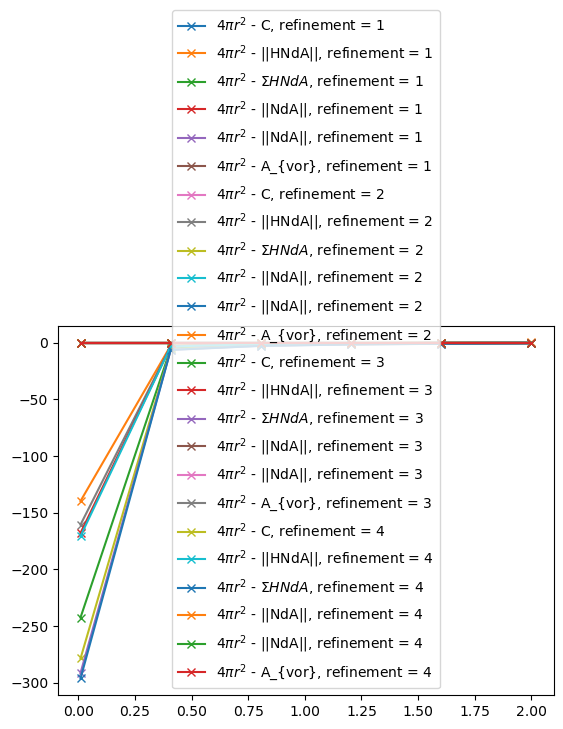

In [7]:
from matplotlib import pyplot as plt

refinement = 2
refinement_list = [1, 2, 3, 4]
#refinement_list = [2]
r_range = np.linspace(1e-2, 2, 6)
for refinement in refinement_list:
    C_list = []
    dA_vor_list = []
    n_hndA_list = []
    s_hndA_list = []
    int_hndA_list = []
    NdA_list = []
    Omega_list = []
    for r in r_range:
        # Start main loop
        HC = sphere_from_cap(r, N=N, refinement=refinement)
      #  HC.V.merge_all(1e-10)
      #  HC.V.merge_all(1e-6)
        HNdA_ijk_l, C_ijk_l = [], []
        int_hndA = []
        C = 0
        HNdA = np.zeros(3)
        da_vor = 0.0
        for v in HC.V:
            n_i = v.x_a - np.array([0.0, 0.0, 0.0])  # First approximation
            n_i = normalized(n_i)[0]  
            n_test = n_i + (np.random.rand(3) - 0.5)
            HNdA_i, C_i = hndA_i(v, n_i=n_test)
            dA_vor_i, C_i = dA_vor(v, n_i=n_test)
            #v.hnda_i = HNdA_i
            v.hnda_i = np.abs(HNdA_i)
            C += C_i
            HNdA += np.abs(HNdA_i)
            da_vor += dA_vor_i
            #print(f"np.dot(n_i, HNdA_i)/C_i, n_i, HNdA_i = {np.dot(n_i, HNdA_i)/C_i}")
            #break
      #  for v in HC.V:
      #      int_HNdA_i, C_i = int_hndA_i(v, n_i=None)
            #int_HNdA_i =-np.array(int_HNdA_i)
      #      int_hndA.append(int_HNdA_i)
      #      int_hndA.append(np.abs(int_HNdA_i))

       # int_hndA_list.append((4*np.pi*r**2 - np.sum(np.linalg.norm(int_hndA, axis=1)))/4*np.pi*r**2)
        n_hndA_list.append((4*np.pi*r**2 - np.linalg.norm(HNdA))/(4*np.pi*r**2))
        s_hndA_list.append((4*np.pi*r**2 - np.sum(HNdA))/(4*np.pi*r**2))
        dA_vor_list.append((4*np.pi*r**2 - da_vor)/(4*np.pi*r**2))
        # Compute the curvature
      #  HNdA_i = []  # total HNdA_i at vertex i
        A_ijk = []  # total HNdA_i for edge ij
        C_ij = []
        alpha_ij = []
        NdA_i = []
        Omega_i = []
        for v in HC.V:
            #print(f'v.index = {v.index}')
            N_f0 = v.x_a - np.array([0.0, 0.0, 0.0])  # First approximation
            N_f0 = normalized(N_f0)[0]
            F, nn = vectorise_vnn(v)
            # Compute discrete curvatures
            c_outd = b_curvatures_hn_ij_c_ij(F, nn, n_i=N_f0)
            # Append lists
          #  c_outd['HNdA_ij']
          #  HNdA_i.append(c_outd['HNdA_i'])
            C_ij.append(c_outd['C_ij'])
            alpha_ij.append(c_outd['alpha_ij'])
            A_ijk.append(c_outd['A_ijk'])
            #print(f'N_f0 dot = {N_f0}')
          #  np.dot(N_f0, c_outd['HNdA_i'])
            NdA_i.append(c_outd['NdA_i'])
            Omega_i.append(2 * np.pi - np.sum(c_outd['Theta_i_jk']))


        NdA_i = np.abs(np.array(NdA_i))
        C_list.append((4*np.pi*r**2 - C)/(4*np.pi*r**2))
        NdA_list.append((4*np.pi*r**2 - np.sum(np.linalg.norm(NdA_i, axis=1)))/(4*np.pi*r**2))
       # NdA_list.append((4*np.pi*r**2 - np.sum(NdA_i, axis=1))/4*np.pi*r**2)
        Omega_list.append((4*np.pi*r**2 - np.sum(Omega_i))/(4*np.pi*r**2))
        

    labstr = r'$4\pi r^2$ - C' + f', refinement = {refinement}'
    plt.plot(r_range, C_list, 'x-', label=labstr)
    labstr = r'$4\pi r^2$ - ||HNdA||' + f', refinement = {refinement}'
    plt.plot(r_range, n_hndA_list, 'x-', label=labstr)
    labstr = r'$4\pi r^2$ - $\Sigma HNdA$' + f', refinement = {refinement}'
    plt.plot(r_range, s_hndA_list, 'x-', label=labstr)
    labstr = r'$4\pi r^2$ - ||NdA||' + f', refinement = {refinement}'
    plt.plot(r_range, NdA_list, 'x-', label=labstr)
    labstr = r'$4\pi r^2$ - ||NdA||' + f', refinement = {refinement}'
    plt.plot(r_range, NdA_list, 'x-', label=labstr)
    labstr = r'$4\pi r^2$ - A_{vor}' + f', refinement = {refinement}'
    plt.plot(r_range, dA_vor_list, 'x-', label=labstr)

    #labstr = r'$4\pi r^2 - \Omega$' + f', refinement = {refinement}'
    #plt.plot(r_range, Omega_list, 'x-', label=labstr)
  #  labstr = r'$4\pi r^2 - \int HNdA$' + f', refinement = {refinement}'
  #  plt.plot(r_range, int_hndA_list, 'x-', label=labstr)
    plt.legend()

plt.show()

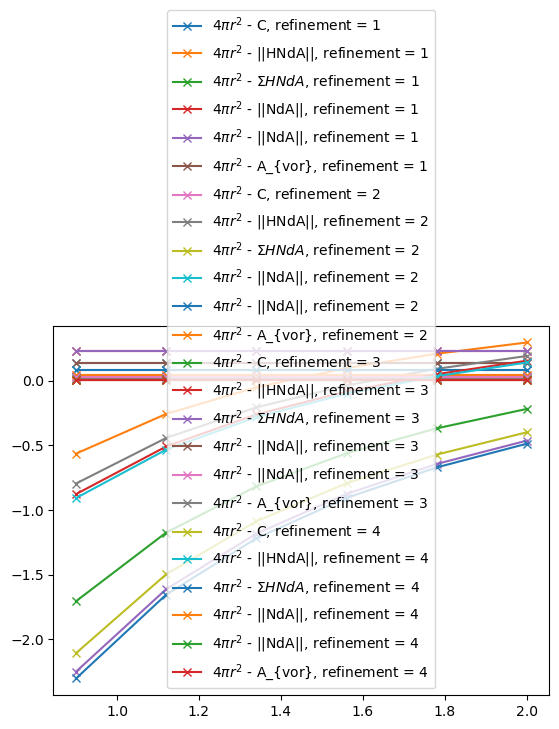

In [43]:
from matplotlib import pyplot as plt

refinement = 2
refinement_list = [1, 2, 3, 4]
#refinement_list = [2]
r_range = np.linspace(0.9, 2, 6)
for refinement in refinement_list:
    C_list = []
    dA_vor_list = []
    n_hndA_list = []
    s_hndA_list = []
    int_hndA_list = []
    NdA_list = []
    Omega_list = []
    for r in r_range:
        # Start main loop
        HC = sphere_from_cap(r, N=N, refinement=refinement)
      #  HC.V.merge_all(1e-10)
      #  HC.V.merge_all(1e-6)
        HNdA_ijk_l, C_ijk_l = [], []
        int_hndA = []
        C = 0
        HNdA = np.zeros(3)
        da_vor = 0.0
        for v in HC.V:
            n_i = v.x_a - np.array([0.0, 0.0, 0.0])  # First approximation
            n_i = normalized(n_i)[0]  
            n_test = n_i + (np.random.rand(3) - 0.5)
            HNdA_i, C_i = hndA_i(v, n_i=n_test)
            dA_vor_i, C_i = dA_vor(v, n_i=n_test)
            #v.hnda_i = HNdA_i
            v.hnda_i = np.abs(HNdA_i)
            C += C_i
            HNdA += np.abs(HNdA_i)
            da_vor += dA_vor_i
            #print(f"np.dot(n_i, HNdA_i)/C_i, n_i, HNdA_i = {np.dot(n_i, HNdA_i)/C_i}")
            #break
      #  for v in HC.V:
      #      int_HNdA_i, C_i = int_hndA_i(v, n_i=None)
            #int_HNdA_i =-np.array(int_HNdA_i)
      #      int_hndA.append(int_HNdA_i)
      #      int_hndA.append(np.abs(int_HNdA_i))

       # int_hndA_list.append((4*np.pi*r**2 - np.sum(np.linalg.norm(int_hndA, axis=1)))/4*np.pi*r**2)
        n_hndA_list.append((4*np.pi*r**2 - np.linalg.norm(HNdA))/(4*np.pi*r**2))
        s_hndA_list.append((4*np.pi*r**2 - np.sum(HNdA))/(4*np.pi*r**2))
        dA_vor_list.append((4*np.pi*r**2 - da_vor)/(4*np.pi*r**2))
        # Compute the curvature
      #  HNdA_i = []  # total HNdA_i at vertex i
        A_ijk = []  # total HNdA_i for edge ij
        C_ij = []
        alpha_ij = []
        NdA_i = []
        Omega_i = []
        for v in HC.V:
            #print(f'v.index = {v.index}')
            N_f0 = v.x_a - np.array([0.0, 0.0, 0.0])  # First approximation
            N_f0 = normalized(N_f0)[0]
            F, nn = vectorise_vnn(v)
            # Compute discrete curvatures
            c_outd = b_curvatures_hn_ij_c_ij(F, nn, n_i=N_f0)
            # Append lists
          #  c_outd['HNdA_ij']
          #  HNdA_i.append(c_outd['HNdA_i'])
            C_ij.append(c_outd['C_ij'])
            alpha_ij.append(c_outd['alpha_ij'])
            A_ijk.append(c_outd['A_ijk'])
            #print(f'N_f0 dot = {N_f0}')
          #  np.dot(N_f0, c_outd['HNdA_i'])
            NdA_i.append(c_outd['NdA_i'])
            Omega_i.append(2 * np.pi - np.sum(c_outd['Theta_i_jk']))


        NdA_i = np.abs(np.array(NdA_i))
        C_list.append((4*np.pi*r**2 - C)/(4*np.pi*r**2))
        NdA_list.append((4*np.pi*r**2 - np.sum(np.linalg.norm(NdA_i, axis=1)))/(4*np.pi*r**2))
       # NdA_list.append((4*np.pi*r**2 - np.sum(NdA_i, axis=1))/4*np.pi*r**2)
        Omega_list.append((4*np.pi*r**2 - np.sum(Omega_i))/(4*np.pi*r**2))
        

    labstr = r'$4\pi r^2$ - C' + f', refinement = {refinement}'
    plt.plot(r_range, C_list, 'x-', label=labstr)
    labstr = r'$4\pi r^2$ - ||HNdA||' + f', refinement = {refinement}'
    plt.plot(r_range, n_hndA_list, 'x-', label=labstr)
    labstr = r'$4\pi r^2$ - $\Sigma HNdA$' + f', refinement = {refinement}'
    plt.plot(r_range, s_hndA_list, 'x-', label=labstr)
    labstr = r'$4\pi r^2$ - ||NdA||' + f', refinement = {refinement}'
    plt.plot(r_range, NdA_list, 'x-', label=labstr)
    labstr = r'$4\pi r^2$ - ||NdA||' + f', refinement = {refinement}'
    plt.plot(r_range, NdA_list, 'x-', label=labstr)
    labstr = r'$4\pi r^2$ - A_{vor}' + f', refinement = {refinement}'
    plt.plot(r_range, dA_vor_list, 'x-', label=labstr)

    #labstr = r'$4\pi r^2 - \Omega$' + f', refinement = {refinement}'
    #plt.plot(r_range, Omega_list, 'x-', label=labstr)
  #  labstr = r'$4\pi r^2 - \int HNdA$' + f', refinement = {refinement}'
  #  plt.plot(r_range, int_hndA_list, 'x-', label=labstr)
    plt.legend()

plt.show()

In [8]:
#help(HC.V.merge_all)
print(HC.V.size())
HC.V.merge_all(1e-9)
print(HC.V.size())

1538
1538


In [9]:
C, np.sum(HNdA), da_vor

(50.07409700972073164, 74.71545639293439, array([50.03793191]))

In [14]:
4*np.pi*r**2, C, np.sum(HNdA), np.linalg.norm(HNdA), np.sum(NdA_i), np.sum(np.linalg.norm(NdA_i, axis=1)), da_vor

(50.26548245743669,
 50.07409700972073164,
 74.71545639293439,
 43.13763343834042,
 74.308687550537405424,
 49.86470252058837932,
 array([50.03793191]))

In [15]:
4*np.pi*r**2, C, np.sum(np.linalg.norm(NdA_i, axis=1)), da_vor[0]

(50.26548245743669,
 50.07409700972073164,
 49.86470252058837932,
 50.037931905799844)

In [16]:
4*np.pi*r**2, C, np.sum(HNdA), np.linalg.norm(HNdA), np.sum(NdA_i), np.sum(np.linalg.norm(NdA_i, axis=1))

(50.26548245743669,
 50.07409700972073164,
 74.71545639293439,
 43.13763343834042,
 74.308687550537405424,
 49.86470252058837932)

In [18]:
4*np.pi*r**2, C, np.sum(np.linalg.norm(NdA_i, axis=1)), da_vor[0]

(50.26548245743669,
 50.07409700972073164,
 49.86470252058837932,
 50.037931905799844)

In [27]:
C/da_vor[0] * C,  da_vor[0]/C * da_vor[0]  #/(4*np.pi*r**2)

(50.11028825210681506, 50.0379319057998444, 50.00179292146612325)

In [34]:
(C/da_vor[0])**2 * da_vor[0], (da_vor[0]/C)**2

(50.11028825210681506, 0.99855605807049157137)

In [39]:
(C/np.sum(np.linalg.norm(NdA_i, axis=1)))**2  *  np.sum(np.linalg.norm(NdA_i, axis=1))

50.284370799237176203

In [41]:
(C/np.sum(np.linalg.norm(NdA_i, axis=1)))  *  np.sum(np.linalg.norm(NdA_i, axis=1))

50.07409700972073164

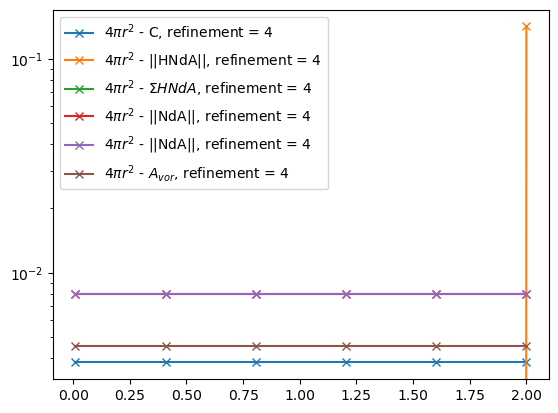

In [23]:
labstr = r'$4\pi r^2$ - C' + f', refinement = {refinement}'
plt.semilogy(r_range, C_list, 'x-', label=labstr)
labstr = r'$4\pi r^2$ - ||HNdA||' + f', refinement = {refinement}'
plt.semilogy(r_range, n_hndA_list, 'x-', label=labstr)
labstr = r'$4\pi r^2$ - $\Sigma HNdA$' + f', refinement = {refinement}'
plt.semilogy(r_range, s_hndA_list, 'x-', label=labstr)
labstr = r'$4\pi r^2$ - ||NdA||' + f', refinement = {refinement}'
plt.semilogy(r_range, NdA_list, 'x-', label=labstr)
labstr = r'$4\pi r^2$ - ||NdA||' + f', refinement = {refinement}'
plt.semilogy(r_range, NdA_list, 'x-', label=labstr)
labstr = r'$4\pi r^2$ - $A_{vor}$' + f', refinement = {refinement}'
plt.semilogy(r_range, dA_vor_list, 'x-', label=labstr)

#labstr = r'$4\pi r^2 - \Omega$' + f', refinement = {refinement}'
#plt.plot(r_range, Omega_list, 'x-', label=labstr)
#labstr = r'$4\pi r^2 - \int HNdA$' + f', refinement = {refinement}'
#plt.semilogy(r_range, int_hndA_list, 'x-', label=labstr)
plt.legend()


### Normalised errors showing decent performance (note there are issues for larger sphere radii which is likely due to the discretisation of this particular test case and related to the need to merge vertices)